## Feature Selection
In this notebook we will apply feature engineering to the manual engineered features built in two previous kernels. We will reduce the number of features using several methods and then we will test the performance of the features using a fairly basic gradient boosting machine model.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

- train_bureau is the training features built manually using the bureau and bureau_balance data
- train_previous is the training features built manually using the previous, cash, credit, and installments data

We first will see how many features we built over the manual engineering process. Here we use a couple of set operations to find the columns that are only in the bureau, only in the previous, and in both dataframes, indicating that there are original features from the application dataframe. Here we are working with a small subset of the data in order to not overwhelm the kernel.

In [ ]:
# Read in data
train_bureau = pd.read_csv('../data/processed/train_bureau_raw.csv')
test_bureau = pd.read_csv('../data/processed/test_bureau_raw.csv')

train_previous = pd.read_csv('../data/processed/train_previous_raw.csv')
test_previous = pd.read_csv('../data/processed/test_previous_raw.csv')

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [41]:
print('Training Bureau Size: ', train_bureau.shape)
print('Testing Bureau Size: ', test_bureau.shape)
print('Training Previous Size: ', train_previous.shape)
print('Testing Previous Size: ', test_previous.shape)

Training Bureau Size:  (307511, 333)
Testing Bureau Size:  (48744, 332)
Training Previous Size:  (307511, 1427)
Testing Previous Size:  (48744, 1426)


In [40]:
print('There are %d bureau columns.' % len(bureau_columns))
print('There are %d previous columns.' % len(previous_columns))

There are 333 bureau columns.
There are 1427 previous columns.


In [42]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 122 original features.
There are 211 bureau and bureau balance features.
There are 1305 previous Home Credit loan features.


In [43]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1638)
Testing shape:  (48744, 1637)


Next we want to one-hot encode the dataframes. This doesn't give the full features since we are only working with a sample of the data and this will not create as many columns as one-hot encoding the entire dataset would.

In [ ]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1758)
Testing shape:  (48744, 1758)


### Remove Collinear Variables
Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. Clearly, these are three things we want to increase, so removing collinear variables is a useful step.

In [ ]:
'''
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()
'''

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,1.000000,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,0.000973,...,0.000553,0.002073,0.000976,0.000072,0.001396,0.002300,0.001281,0.000270,0.000510,0.002549
CNT_CHILDREN,0.001129,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,...,0.001830,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525
AMT_INCOME_TOTAL,0.001820,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,...,0.000718,0.011696,0.006149,0.023886,0.003886,0.032753,0.016523,0.003369,0.050174,0.002894
AMT_CREDIT,0.000343,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,...,0.000869,0.014314,0.007987,0.027255,0.005799,0.046644,0.009756,0.007373,0.058256,0.004308
AMT_ANNUITY,0.000433,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,0.104332,0.038514,...,0.002166,0.015589,0.010077,0.035318,0.005968,0.054988,0.009189,0.007711,0.068145,0.003910


In [ ]:
'''
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()
'''

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,NaN,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,0.000973,...,0.000553,0.002073,0.000976,0.000072,0.001396,0.002300,0.001281,0.000270,0.000510,0.002549
CNT_CHILDREN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,...,0.001830,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525
AMT_INCOME_TOTAL,NaN,NaN,NaN,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,...,0.000718,0.011696,0.006149,0.023886,0.003886,0.032753,0.016523,0.003369,0.050174,0.002894
AMT_CREDIT,NaN,NaN,NaN,NaN,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,...,0.000869,0.014314,0.007987,0.027255,0.005799,0.046644,0.009756,0.007373,0.058256,0.004308
AMT_ANNUITY,NaN,NaN,NaN,NaN,NaN,0.775109,0.118429,0.009445,0.104332,0.038514,...,0.002166,0.015589,0.010077,0.035318,0.005968,0.054988,0.009189,0.007711,0.068145,0.003910


In [ ]:
'''
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
'''

There are 893 columns to remove.


In [ ]:
'''
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)
'''

Training shape:  (307511, 865)
Testing shape:  (48744, 865)


In [2]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.

    Input:
        threshold: the threshold above which for
        collinearity is to be considered
    Output:
        dataframe with columns removed that are above the threshold
    '''
    corr_matrix = x.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print('There are %d columns to remove.' % (len(to_drop)))
    x = x.drop(to_drop, axis=1)
    return x

In [ ]:
'''
train = remove_collinear_features(train, 0.9)
test = remove_collinear_features(test, 0.9)
train['TARGET'] = train_labels
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

train.to_csv('../data/processed/train_collinear_removed.csv', index = False)
test.to_csv('../data/processed/test_collinear_removed.csv', index = False)
'''

In [10]:
train = pd.read_csv('../data/processed/train_collinear_removed.csv')
test = pd.read_csv('../data/processed/test_collinear_removed.csv')

In [11]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 866)
Testing set full shape:  (48744, 865)


### Remove Missing Values
A relatively simple choice of feature selection is removing missing values. Well, it seems simple, at least until we have to decide what percentage of missing values is the minimum threshold for removing a column. Like many choices in machine learning, there is no right answer, and not even a general rule of thumb for making this choice. In this implementation, if any columns have greater than 75% missing values, they will be removed.

In [12]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_max_max             0.801438
client_credit_AMT_PAYMENT_CURRENT_min_mean            0.801438
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_mean      0.801178
client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max       0.801178
client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean    0.801178
dtype: float64

In [13]:
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_mean    0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_min_max       0.773223
client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_max     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_max_mean      0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_max    0.773223
dtype: float64

In [14]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 18 columns with more than 75% missing values


Let's drop the columns, one-hot encode the dataframes, and then align the columns of the dataframes.

In [15]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 847)
Testing set full shape:  (48744, 847)


In [16]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])

### Feature Selection through Feature Importances
The next method we can employ for feature selection is to use the feature importances of a model. Tree-based models (and consequently ensembles of trees) can determine an "importance" for each feature by measuring the reduction in impurity for including the feature in the model.

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(train, train_labels)

RandomForestClassifier(random_state=42)

In [18]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
feature_importance_df.head(20)

,Feature,Importance
25,EXT_SOURCE_2,0.018632
26,EXT_SOURCE_3,0.014474
24,EXT_SOURCE_1,0.007862
5,DAYS_BIRTH,0.007248
655,client_installments_AMT_PAYMENT_min_sum,0.006658
109,bureau_DAYS_CREDIT_mean,0.006156
372,client_installments_AMT_PAYMENT_min_max,0.006132
7,DAYS_REGISTRATION,0.006130
110,bureau_DAYS_CREDIT_max,0.006070
8,DAYS_ID_PUBLISH,0.006025


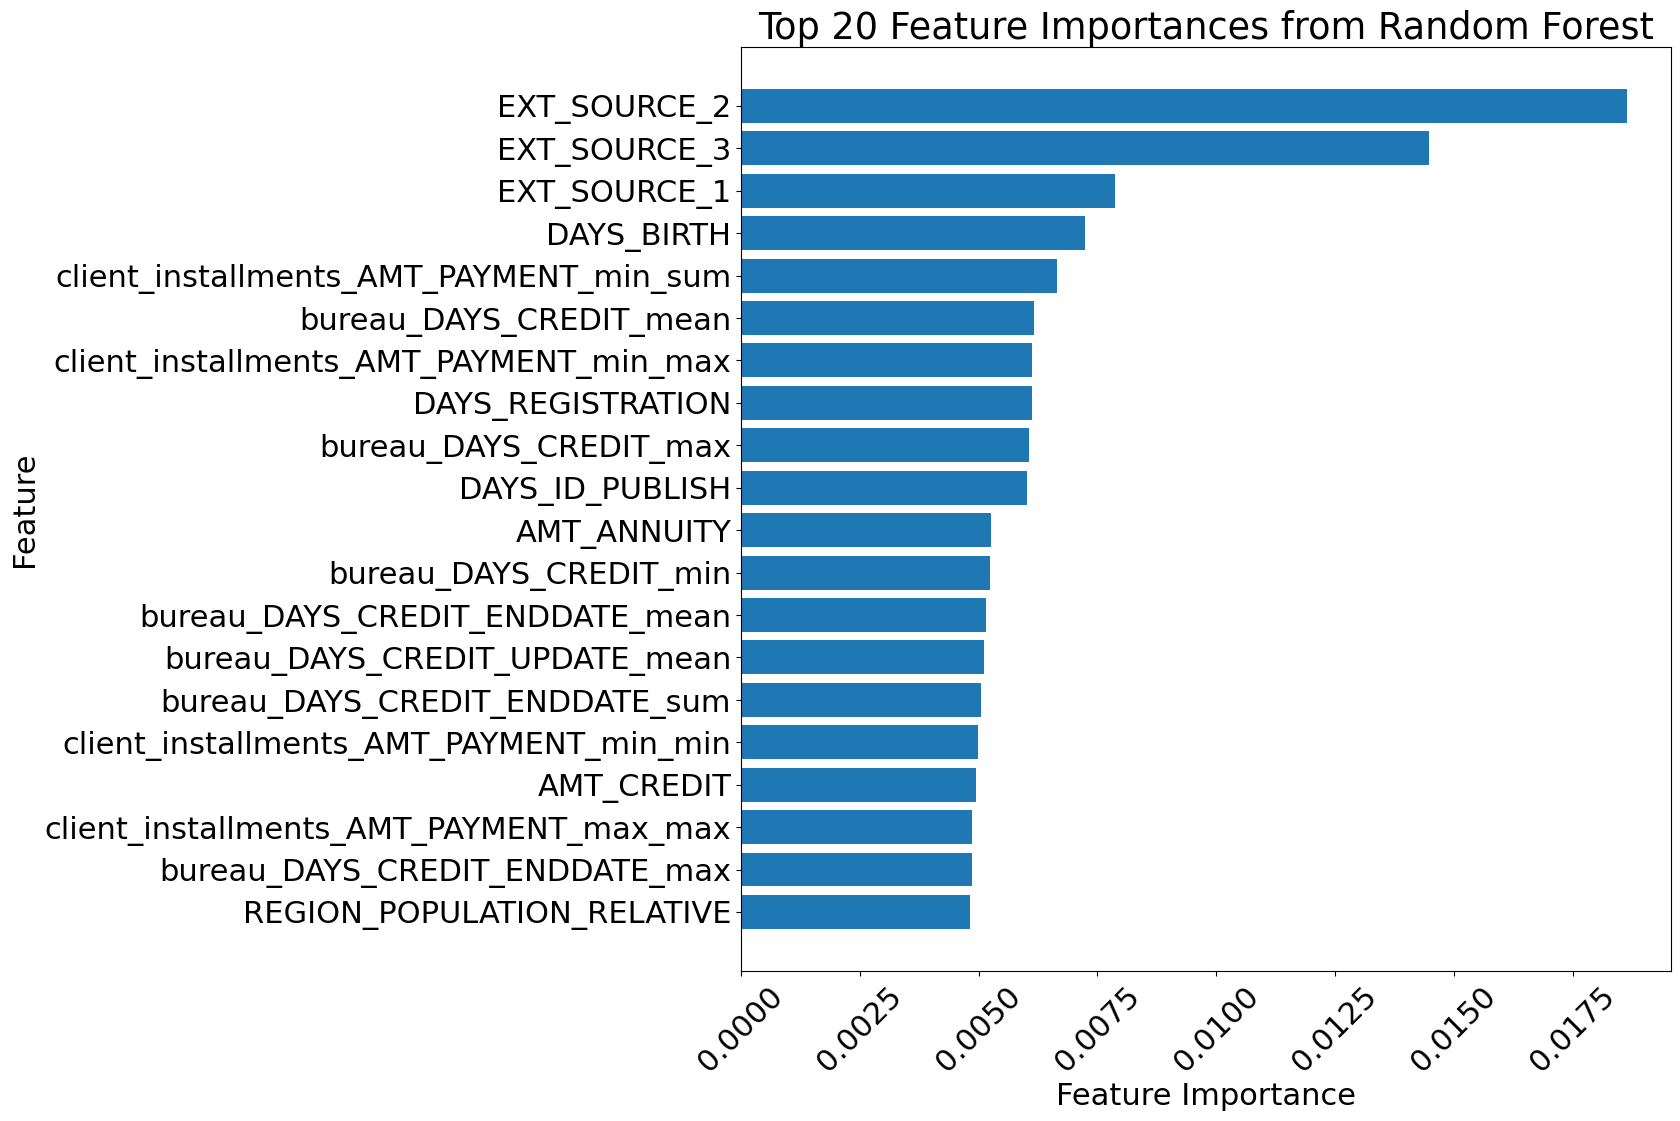

In [19]:
plt.figure(figsize=(12, 12))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances from Random Forest")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [20]:

def cumulative_feature_importance(feature_importance_df, threshold=0.95):
    """
    Calculates cumulative feature importance and identifies the minimum number of features
    needed to reach a specified threshold.

    Args:
        feature_importance_df (pd.DataFrame): DataFrame with 'Feature' and 'Importance' columns.
        threshold (float): The cumulative importance threshold (default is 0.95).

    Returns:
        tuple: A tuple containing:
            - int: The minimum number of features to reach the threshold.
            - pd.DataFrame: DataFrame with cumulative importance added.
    """

    # Sort features by importance in descending order
    cumulative_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Calculate cumulative importance
    cumulative_importance_df['Cumulative Importance'] = cumulative_importance_df['Importance'].cumsum()
    cumulative_importance_df = cumulative_importance_df[cumulative_importance_df['Cumulative Importance'] <= threshold].reset_index(drop=True)

    # Find the minimum number of features to reach the threshold
    n_features = cumulative_importance_df.shape[0]

    return n_features, cumulative_importance_df

# Example usage:
n_features, cumulative_importance_df = cumulative_feature_importance(feature_importance_df, 0.95)

print(f"Number of features needed to reach required cumulative importance: {n_features}")
cumulative_importance_df.head(n_features)

Number of features needed to reach required cumulative importance: 498


,Feature,Importance,Cumulative Importance
0,EXT_SOURCE_2,0.018632,0.018632
1,EXT_SOURCE_3,0.014474,0.033106
2,EXT_SOURCE_1,0.007862,0.040968
3,DAYS_BIRTH,0.007248,0.048215
4,client_installments_AMT_PAYMENT_min_sum,0.006658,0.054874
...,...,...,...
493,previous_NAME_SELLER_INDUSTRY_Clothing_count,0.000380,0.948378
494,bureau_CNT_CREDIT_PROLONG_max,0.000378,0.948756
495,previous_NAME_TYPE_SUITE_Other_A_count,0.000377,0.949133
496,bureau_CREDIT_TYPE_Car loan_count,0.000375,0.949508


In [21]:
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 846)
Testing shape:  (48744, 846)


In [22]:
n_features, cumulative_importance_df = cumulative_feature_importance(feature_importance_df, 0.95)
features_to_keep = cumulative_importance_df['Feature'].tolist()

print(features_to_keep)

['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'DAYS_BIRTH', 'client_installments_AMT_PAYMENT_min_sum', 'bureau_DAYS_CREDIT_mean', 'client_installments_AMT_PAYMENT_min_max', 'DAYS_REGISTRATION', 'bureau_DAYS_CREDIT_max', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 'bureau_DAYS_CREDIT_min', 'bureau_DAYS_CREDIT_ENDDATE_mean', 'bureau_DAYS_CREDIT_UPDATE_mean', 'bureau_DAYS_CREDIT_ENDDATE_sum', 'client_installments_AMT_PAYMENT_min_min', 'AMT_CREDIT', 'client_installments_AMT_PAYMENT_max_max', 'bureau_DAYS_CREDIT_ENDDATE_max', 'REGION_POPULATION_RELATIVE', 'DAYS_LAST_PHONE_CHANGE', 'bureau_DAYS_CREDIT_sum', 'bureau_DAYS_CREDIT_UPDATE_min', 'client_installments_AMT_INSTALMENT_min_sum', 'client_installments_AMT_PAYMENT_max_min', 'DAYS_EMPLOYED', 'client_installments_AMT_INSTALMENT_max_mean', 'bureau_DAYS_CREDIT_ENDDATE_min', 'client_installments_AMT_INSTALMENT_mean_max', 'previous_HOUR_APPR_PROCESS_START_mean', 'bureau_DAYS_ENDDATE_FACT_mean', 'previous_DAYS_DECISION_max', 'previous_DAYS_DECISION_mea

In [23]:
train_small = train[features_to_keep]
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small = test[features_to_keep]
test_small['SK_ID_CURR'] = test_ids

display(train_small.head())
display(test_small.head())

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_mean,client_installments_AMT_PAYMENT_min_max,DAYS_REGISTRATION,bureau_DAYS_CREDIT_max,DAYS_ID_PUBLISH,...,OCCUPATION_TYPE_Core staff,previous_NAME_CASH_LOAN_PURPOSE_Urgent needs_count,client_cash_NAME_CONTRACT_STATUS_Approved_count_norm_max,previous_NAME_SELLER_INDUSTRY_Clothing_count,bureau_CNT_CREDIT_PROLONG_max,previous_NAME_TYPE_SUITE_Other_A_count,bureau_CREDIT_TYPE_Car loan_count,LIVE_REGION_NOT_WORK_REGION,TARGET,SK_ID_CURR
0,0.262949,0.139376,0.083037,-9461,175783.73,-874.00,9251.775,-3648.0,-103.0,-2120,...,False,0.0,0.0,0.0,0.0,0.0,0.0,0,True,100002
1,0.622246,NaN,0.311267,-16765,1154108.20,-1400.75,98356.990,-1186.0,-606.0,-291,...,True,0.0,0.0,0.0,0.0,0.0,0.0,0,False,100003
2,0.555912,0.729567,NaN,-19046,16071.75,-867.00,5357.250,-4260.0,-408.0,-2531,...,False,0.0,0.0,0.0,0.0,0.0,0.0,0,False,100004
3,0.650442,NaN,NaN,-19005,994476.70,NaN,691786.900,-9833.0,NaN,-2437,...,False,0.0,0.0,0.0,NaN,0.0,NaN,0,False,100006
4,0.322738,NaN,NaN,-19932,483756.38,-1149.00,16046.100,-4311.0,-1149.0,-3458,...,True,0.0,0.0,0.0,0.0,0.0,0.0,0,False,100007


,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,DAYS_BIRTH,client_installments_AMT_PAYMENT_min_sum,bureau_DAYS_CREDIT_mean,client_installments_AMT_PAYMENT_min_max,DAYS_REGISTRATION,bureau_DAYS_CREDIT_max,DAYS_ID_PUBLISH,...,previous_NAME_PAYMENT_TYPE_Non-cash from your account_count,OCCUPATION_TYPE_Core staff,previous_NAME_CASH_LOAN_PURPOSE_Urgent needs_count,client_cash_NAME_CONTRACT_STATUS_Approved_count_norm_max,previous_NAME_SELLER_INDUSTRY_Clothing_count,bureau_CNT_CREDIT_PROLONG_max,previous_NAME_TYPE_SUITE_Other_A_count,bureau_CREDIT_TYPE_Car loan_count,LIVE_REGION_NOT_WORK_REGION,SK_ID_CURR
0,0.789654,0.159520,0.752614,-19241,27746.775,-735.000000,3980.925,-5170.0,-49.0,-812,...,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,100001
1,0.291656,0.432962,0.564990,-18064,43318.800,-190.666667,4813.200,-9118.0,-62.0,-1623,...,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,100005
2,0.699787,0.610991,NaN,-20038,66875.266,-1737.500000,6538.185,-2175.0,-1210.0,-3503,...,0.0,False,0.0,0.0,0.0,0.0,0.0,2.0,0,100013
3,0.509677,0.612704,0.525734,-13976,172044.310,-1401.750000,6996.735,-2000.0,-269.0,-4208,...,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0,100028
4,0.425687,NaN,0.202145,-13040,133169.400,NaN,11097.450,-4000.0,NaN,-4262,...,0.0,False,0.0,0.0,0.0,NaN,0.0,NaN,0,100038


In [24]:
train_small.to_csv('../data/processed/train_compressed.csv', index = False)
test_small.to_csv('../data/processed/test_compressed.csv', index = False)